In [ ]:
import os

import numpy as np
import xarray as xr

import pandas as pd
import geopandas as gpd

from shapely.geometry import Point

from scipy.optimize import curve_fit

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import patches
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(0, os.path.abspath("../function"))
from ART_downscale import epl_fun
from ART_preprocessing import spatial_correlation

In [2]:
thresh_OBS = 1
corr_method = 'pearson'

In [21]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy','Veneto.geojson')

if os.path.exists(veneto_dir):
    Veneto = gpd.read_file(veneto_dir)
else:
    raise SystemExit(f"File not found: {veneto_dir}")

## Load Rain Gauge data

In [3]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy','stations','data','Veneto')
data_dir =  os.path.join(dir_base,'VENETO_INFO_1dy.csv')
VENETO_INFO_1dy = pd.read_csv(data_dir)
VENETO_INFO_1dy.head(4)

,File_Name,Code_Int,Status,Lat,Lon,Elv
0,002_FG_BS,2,OK,45.895600,12.815000,21
1,003_BL_Ar,3,OK,46.499984,11.876073,1642
2,003_FG_BS,3,OK,45.918000,12.545000,22
3,004-264_NP_Be,"[4, 264]",Remove,46.164679,12.244708,379


In [34]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy','stations','data','Veneto')
data_dir =  os.path.join(dir_base,'VENETO_INFO_1dy.csv')
VENETO_INFO_1dy = pd.read_csv(data_dir)

VENETO_INFO_1dy = VENETO_INFO_1dy.sort_values(by='Lon')

radius = 35

## Create a gif

In [ ]:
FIGSIZE = (3, 3)  # Fixed figure size
DPI = 300  # Fixed resolution
EXTENT = [10.5, 13.2, 44.7, 46.8]  # Fixed extent for the map

for nn in range(len(VENETO_INFO_1dy)):
    clat, clon = VENETO_INFO_1dy['Lat'].values[nn], VENETO_INFO_1dy['Lon'].values[nn]

    center = Point(clon, clat)
    circle = center.buffer(radius / 111.32) 
    gdf = gpd.GeoDataFrame(geometry=[circle], crs="EPSG:4326")

    veneto_gdf = gpd.GeoDataFrame(
        VENETO_INFO_1dy,
        geometry=gpd.points_from_xy(VENETO_INFO_1dy["Lon"], VENETO_INFO_1dy["Lat"]),
        crs="EPSG:4326"
    )

    points_within_circle = veneto_gdf[veneto_gdf.geometry.within(circle)]
    points_within_circle.reset_index(inplace=True)

    if len(points_within_circle) - 1 >= 10:
        cmap = plt.cm.Spectral_r
        proj = ccrs.PlateCarree()

        # Create figure with fixed size and resolution
        fig = plt.figure(figsize=FIGSIZE, dpi=DPI, constrained_layout=True)
        gs = gridspec.GridSpec(1, 1, figure=fig)
        
        ax3 = fig.add_subplot(gs[0, 0], projection=proj)

        # Scatter plots
        ax3.scatter(clon, clat, s=2, c='k', zorder=20, label='Nearest Neighbour')
        ax3.scatter(points_within_circle['Lon'], points_within_circle['Lat'], s=0.5, c='r', zorder=10, label='Station inside')
        ax3.scatter(VENETO_INFO_1dy['Lon'], VENETO_INFO_1dy['Lat'], s=0.5, c='grey', zorder=8, label='Total Stations')

        # Plot the circle geometry
        gdf.plot(ax=ax3, linewidth=0.8, facecolor='none', edgecolor='k')
        ax3.set_aspect('auto', adjustable='datalim') # Ensures the aspect ratio doesn't fluctuate when plotting dynamic geometries

        ax3.set_extent(EXTENT, crs=proj)  # Set the fixed extent
        ax3.add_feature(cf.COASTLINE, linewidth=0.1, linestyle='-', edgecolor='k')
        ax3.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.6, alpha=0.5)

        # Gridlines and labels
        gl = ax3.gridlines(crs=proj, draw_labels=True, linewidth=0.2, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.bottom_labels = False
        gl.right_labels = False
        gl.left_labels = False
        gl.xlabel_style = {'size': 4, 'color': 'k'}
        gl.ylabel_style = {'size': 4, 'color': 'k'}

        # Background color
        ax3.set_facecolor('white')
        fig.patch.set_alpha(0)

        # Save the figure
        image_dir = f'/home/arturo/github/downpy/fig/OBS_corr/veneto/OBS_corr_{str(nn).zfill(4)}.png'
        plt.savefig(image_dir, transparent=False, bbox_inches=None, pad_inches=0.01)

        plt.close()

    else:
        pass

## Compute the correlation parameters for all points

In [129]:
CORR_eps_veneto = []
CORR_alp_veneto = []
clats = []
clons = []

for nn in range(len(VENETO_INFO_1dy)):#len(VENETO_INFO_1dy)
    clat, clon = VENETO_INFO_1dy['Lat'].values[nn], VENETO_INFO_1dy['Lon'].values[nn]

    center = Point(clon, clat)
    circle = center.buffer(radius / 111.32) 
    gdf = gpd.GeoDataFrame(geometry=[circle], crs="EPSG:4326")

    veneto_gdf = gpd.GeoDataFrame(
        VENETO_INFO_1dy,
        geometry=gpd.points_from_xy(VENETO_INFO_1dy["Lon"], VENETO_INFO_1dy["Lat"]),
        crs="EPSG:4326"
    )

    points_within_circle = veneto_gdf[veneto_gdf.geometry.within(circle)]
    points_within_circle.reset_index(inplace=True)
    
    if len(points_within_circle) - 1 >= 10:

        dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy','stations','data','Veneto')
        CORR_OBS = spatial_correlation(points_within_circle, thresh_OBS, dir_base, 'pearson').dropna()
        CORR_OBS = CORR_OBS[CORR_OBS['corr']>0.6]

        FIT, _ = curve_fit(epl_fun, CORR_OBS['dist'].values, CORR_OBS['corr'].values)
        CORR_eps, CORR_alp = FIT

        clats.append(clat)
        clons.append(clon)
        CORR_eps_veneto.append(CORR_eps)
        CORR_alp_veneto.append(CORR_alp)

    else:
        pass

/home/arturo/github/downpy/function/ART_downscale.py:136: RuntimeWarning: invalid value encountered in scalar power
  myfun[ii] = (epsilon/(np.exp(1)*x[ii]))**alpha
/home/arturo/github/downpy/function/ART_downscale.py:136: RuntimeWarning: invalid value encountered in scalar power
  myfun[ii] = (epsilon/(np.exp(1)*x[ii]))**alpha
/home/arturo/github/downpy/function/ART_downscale.py:136: RuntimeWarning: invalid value encountered in scalar power
  myfun[ii] = (epsilon/(np.exp(1)*x[ii]))**alpha
/home/arturo/github/downpy/function/ART_downscale.py:136: RuntimeWarning: invalid value encountered in scalar power
  myfun[ii] = (epsilon/(np.exp(1)*x[ii]))**alpha
/home/arturo/github/downpy/function/ART_downscale.py:136: RuntimeWarning: invalid value encountered in scalar power
  myfun[ii] = (epsilon/(np.exp(1)*x[ii]))**alpha
/home/arturo/github/downpy/function/ART_downscale.py:136: RuntimeWarning: invalid value encountered in scalar power
  myfun[ii] = (epsilon/(np.exp(1)*x[ii]))**alpha
/home/artu

In [132]:
PARAM = pd.DataFrame({'Lat':clats, 'Lon':clons, 'Eps':CORR_eps_veneto, 'Alp':CORR_alp_veneto})

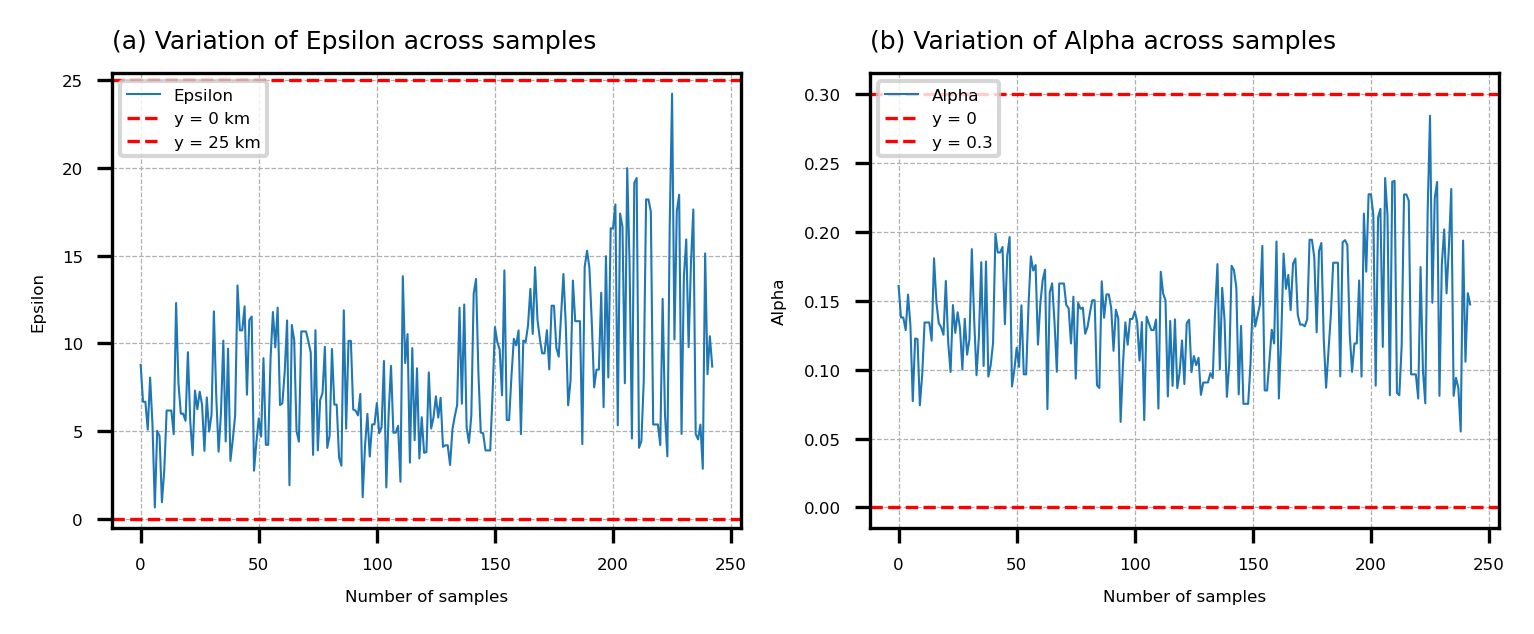

In [164]:
fig = plt.figure(figsize=(5,2),dpi=300, constrained_layout=True)
gs = gridspec.GridSpec(1,2, figure=fig)

# ========================================================================================
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(CORR_eps_veneto, linewidth=0.5, label='Epsilon')

ax1.axhline(y=0, color='r', linestyle='--', linewidth=0.8, label='y = 0 km')
ax1.axhline(y=25, color='r', linestyle='--', linewidth=0.8, label='y = 25 km')

ax1.xaxis.set_tick_params(labelsize=4)
ax1.yaxis.set_tick_params(labelsize=4)
ax1.grid(linewidth=0.3, linestyle='--')

ax1.legend(fontsize=4, loc=2)
ax1.set_title('(a) Variation of Epsilon across samples', loc='left', fontsize=6)
ax1.set_xlabel('Number of samples', fontsize=4)
ax1.set_ylabel('Epsilon', fontsize=4)

# ========================================================================================
ax1 = fig.add_subplot(gs[0, 1])
ax1.plot(CORR_alp_veneto, linewidth=0.5, label='Alpha')

ax1.axhline(y=0, color='r', linestyle='--', linewidth=0.8, label='y = 0')
ax1.axhline(y=0.3, color='r', linestyle='--', linewidth=0.8, label='y = 0.3')

ax1.xaxis.set_tick_params(labelsize=4)
ax1.yaxis.set_tick_params(labelsize=4)
ax1.grid(linewidth=0.3, linestyle='--')

ax1.legend(fontsize=4, loc=2)
ax1.set_title('(b) Variation of Alpha across samples', loc='left', fontsize=6)
ax1.set_xlabel('Number of samples', fontsize=4)
ax1.set_ylabel('Alpha', fontsize=4)

# ========================================================================================
ax1.set_facecolor('white')
fig.patch.set_alpha(0)

In [165]:
clat_test = 46.1149
clon_test = 12.5244

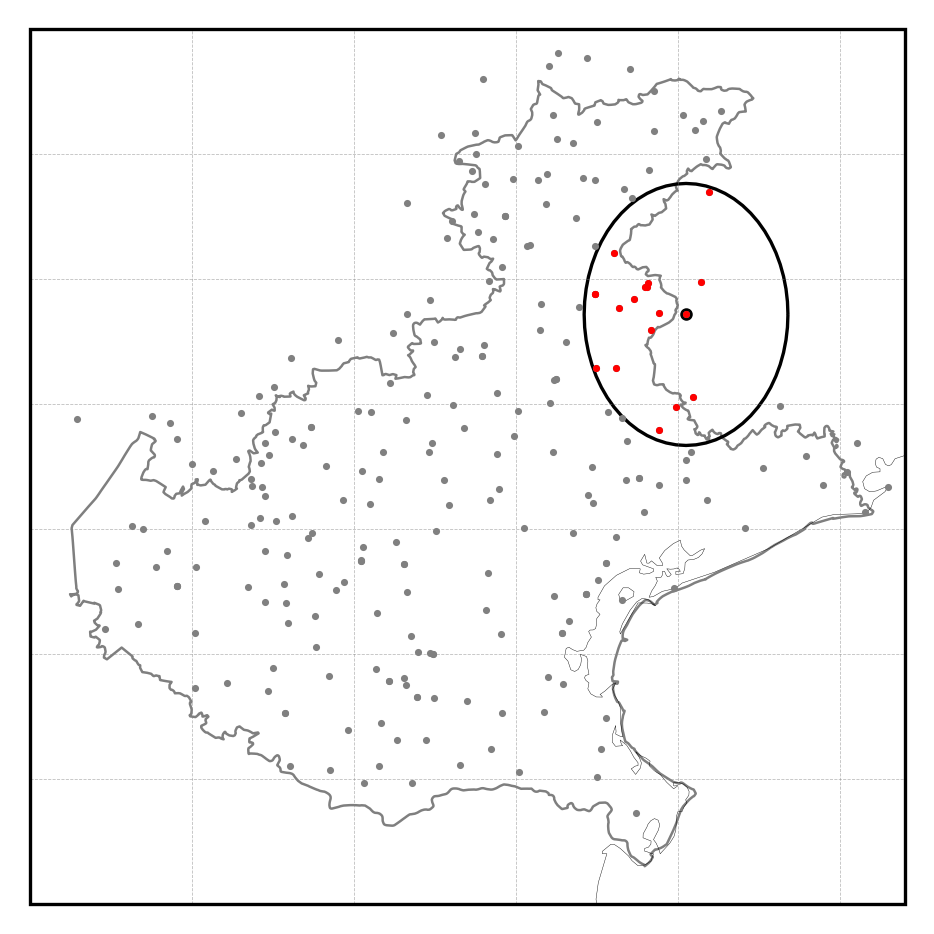

In [166]:
center = Point(clon_test, clat_test)
circle = center.buffer(radius / 111.32) 
gdf = gpd.GeoDataFrame(geometry=[circle], crs="EPSG:4326")

veneto_gdf = gpd.GeoDataFrame(
    VENETO_INFO_1dy,
    geometry=gpd.points_from_xy(VENETO_INFO_1dy["Lon"], VENETO_INFO_1dy["Lat"]),
    crs="EPSG:4326"
)

points_within_circle = veneto_gdf[veneto_gdf.geometry.within(circle)]
points_within_circle.reset_index(inplace=True)

fig = plt.figure(figsize=FIGSIZE, dpi=DPI, constrained_layout=True)
gs = gridspec.GridSpec(1, 1, figure=fig)

ax3 = fig.add_subplot(gs[0, 0], projection=proj)

# Scatter plots
ax3.scatter(clon_test, clat_test, s=4, c='k', zorder=2, label='Nearest Neighbour')
ax3.scatter(points_within_circle['Lon'], points_within_circle['Lat'], s=0.5, c='r', zorder=10, label='Station inside')
ax3.scatter(VENETO_INFO_1dy['Lon'], VENETO_INFO_1dy['Lat'], s=0.5, c='grey', zorder=8, label='Total Stations')

# Plot the circle geometry
gdf.plot(ax=ax3, linewidth=0.8, facecolor='none', edgecolor='k')
ax3.set_aspect('auto', adjustable='datalim') # Ensures the aspect ratio doesn't fluctuate when plotting dynamic geometries

ax3.set_extent(EXTENT, crs=proj)  # Set the fixed extent
ax3.add_feature(cf.COASTLINE, linewidth=0.1, linestyle='-', edgecolor='k')
ax3.add_geometries(Veneto.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.6, alpha=0.5)

# Gridlines and labels
gl = ax3.gridlines(crs=proj, draw_labels=True, linewidth=0.2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

# Background color
ax3.set_facecolor('white')
fig.patch.set_alpha(0)

## Weibull Parameters for Neighborhood